### What does this project simulate?

This project simulates a work scenario: I am an employee in the data & analytics department and I have obtained 490K+ sales data from the sales department, specifically how much money each customer spent on each transaction on our e-commerce website, with the number of transactions, the date and the country of origin, and the invoices of the transactions with their respective unique ID. Taking this huge amount of data and exploring it and finding insights to facilitate better marketing decision-making is my goal. 

**What this project will do?**
To calculate the CLV of this project, the BG-BND model and Gamma-Gamma model will be used to predict user-generated transactions and the monetary value of each transaction. Based on the CLV value of customers, this project finally classified them into different segments.


### Loading Essential Packages 

As well as the usual packages for data processing and analysis, we have also downloaded and installed **Lifetimes**, a package designed specifically for measuring user activity and churn, which will help us calculate and predict CLV more quickly.

In [ ]:
pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt2

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading, Transformation & Pre-processing

In [ ]:
# read data
url =  "https://raw.githubusercontent.com/ugursavci/Customer_Lifetime_Value_Prediction/main/Online_Retail.csv"
data = pd.read_csv(url, encoding="unicode_escape", parse_dates=['InvoiceDate'])
print("Total number of transactions happened in the given period: "+ str(data.shape[0]))
data.head(5)

Total number of transactions happened in the given period: 495478


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Feature selection
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = data[features]
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])
print(data_clv.shape)
data_clv.head()

(495478, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34


In [ ]:
data_clv = data_clv[data_clv['TotalSales'] > 0]
data_clv.describe()

,CustomerID,Quantity,UnitPrice,TotalSales
count,354321.000000,485123.000000,485123.000000,485123.000000
mean,15552.486392,9.610738,3.849679,18.603987
std,1594.527150,161.904143,34.677371,281.280229
min,12346.000000,1.000000,0.001000,0.001000
25%,14194.000000,1.000000,1.250000,3.360000
50%,15522.000000,3.000000,2.100000,8.420000
75%,16931.000000,10.000000,4.130000,16.950000
max,18287.000000,80995.000000,13541.330000,168469.600000


**Data Exploration:**
Exploring the dataset helps us to understand the overall picture of sales to date, including the average sales of individual transactions, customer purchase frequency and churn rate.


In [ ]:
# Printing the details of the dataset
maxdate = data_clv['InvoiceDate'].dt.date.max()
mindate = data_clv['InvoiceDate'].dt.date.min()
unique_cust = data_clv['CustomerID'].nunique()
tot_quantity = data_clv['Quantity'].sum()
tot_sales = data_clv['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 3920
Total Quantity Sold: 4662390
Total Sales for the period: 9025222.084000003


In [ ]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: (x.max() - x.min()).days, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: sum(x)})

customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
CustomerID,,,
12346.0,0,1,77183.60
12747.0,366,103,4196.01
12748.0,372,4595,33719.73
12749.0,209,199,4090.88
12820.0,323,59,942.34


### CLV Calculation & Prediction: Why is it Important?
In this project, the Customer Lifetime Value (CLV) will be predicted using a probabilistic model (BG-BND). CLV is a very important business metric that indicates the value of a customer. Additionally, CLV can show brand loyalty, since a more loyal customer will generate a steady stream of transactions over time. 

By doing this, the project will help the firm find balance in terms of short-term and long-term marketing goals and perform a better understanding of financial return. Specifically, this will help the marketing department to build brand loyalty, reduce new users’ acquisition time and cost and help the sales department to gain better understanding on investment effectiveness.



In [ ]:
# Calculating the necessary variables for CLV calculation
Average_sales = round(np.mean(customer['TotalSales']),2)
print(f"Average sales: ${Average_sales}")

Purchase_freq = round(np.mean(customer['Frequency']), 2)
print(f"Purchase Frequency: {Purchase_freq}")

Retention_rate = customer[customer['Frequency']>1].shape[0]/customer.shape[0]
churn = round(1 - Retention_rate, 2)
print(f"Churn: {churn}%")

Average sales: $1864.39
Purchase Frequency: 90.39
Churn: 0.02%


### Calculating CLV using the Aggregate Model: 
The aggregation/averaging model is the **simplest and oldest** way to calculate CLV. The average spend and churn rate for all customers are assumed to remain constant.


In [ ]:
# Calculating the CLV
Profit_margin = 0.05 

CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
print(f"The Customer Lifetime Value (CLV) for each customer is: ${CLV}")
# a CLV value of $421K for each customer

The Customer Lifetime Value (CLV) for each customer is: $421305.53


### Calculating CLV using the Cohort Model: 
Instead of simply assuming that all customers are a group, the cohort model tries to divide them into multiple groups and calculate the CLV of each group. In this model, all customers are viewed as one group, **which overcomes the main disadvantage of the simple aggregation model.**


In [ ]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346.0,1,1,77183.60
12747.0,12,103,4196.01
12748.0,12,4595,33719.73
12749.0,5,199,4090.88
12820.0,1,59,942.34


In [ ]:
# calculating CLV for each month
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]
    
    Average_sales = round(np.mean(customer_m['TotalSales']),2)
    
    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)
    
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
    
    Monthly_CLV.append(CLV)

In [ ]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLV'])
display(monthly_clv.style.background_gradient())

,Months,CLV
0,Jan,676926.180000
1,Feb,320818.540000
2,March,516225.910000
3,Apr,345562.700000
4,May,138948.540000
5,Jun,267404.310000
6,Jul,47050.790000
7,Aug,118834.870000
8,Sep,180261.890000
9,Oct,66488.380000


### Introduction to Predictive Method: Adopting Probablistic Model
**1. Explaining the construction and applicability of BG-BND Model**

There have been many CLV models developed with varying degrees of complexity and accuracy, from crude heuristics to complex probability frameworks. In this project, we will eventually use the BG-BND model, which is applicable to "non-contractual, continuous" purchases, which are transactions on e-commerce platforms, to apply it to our current dataset. 

However, the BG-BND model cannot do everything, so we must also understand its limitations. It should be clear that the model only deals with one component of the CLV calculation, namely the prediction of the number of purchases.


**2. Prediction of CLV: Number of Purchase & Value of Purchase**

The prediction of CLV is generally based on two aspects since CLV = number of purchase x monetary value of each purchase. Therefore, we use the BG-BND model to solve the prediction of the number of transactions, while the Gamma-Gamma model will be introduced to solve the prediction of monetary value.

Meanwhile, there is a Python package named Lifetimes, which is mainly used to help calculate customer lifecycle value, predict customer churn, etc.. It has all the major models and utility functions needed for CLV calculations.


### Predicting CLV using BG-BND & Gamma-Gamma 

**Creating Summary Data & Calculating Frequency, Recency, T & Monetary Value:**

Creating summary data using the built-in functions in Lifetimes helps us aggregate transaction-level data to the customer level and calculate the frequency, recency, T and monetary values for each customer. 

Customers with recency 0 are one-time buyers, and these customers behave differently when it comes to purchasing than those with more loyalty, so we should actually focus on those with more loyalty.


In [ ]:
# creating summary dataset
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID', 'InvoiceDate', 'TotalSales' )
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12747.0,10.0,367.0,369.0,383.745000
2,12748.0,112.0,373.0,373.0,301.024821
3,12749.0,3.0,210.0,213.0,1077.260000
4,12820.0,3.0,323.0,326.0,257.293333


count    3920.000000
mean        2.850000
std         5.713358
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       112.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.66 %


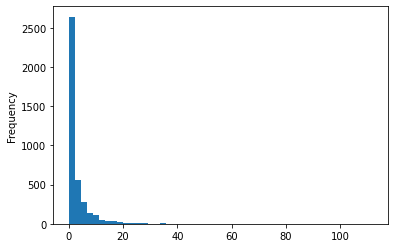

In [ ]:
# understanding distribution of frequency
summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [ ]:
# fitting the BG-NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 3920 subjects, a: 0.01, alpha: 69.64, b: 7.96, r: 0.83>

Print this table showing the values of the distribution parameters estimated from the historical data. The model now uses it to predict future transactions and customer churn.
Thus, we continue to understand whether customers are still active or have churned now based on historical data.


In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.833433,0.028549,0.777477,0.889389
alpha,69.637792,2.788365,64.172597,75.102988
a,0.005493,0.013933,-0.021816,0.032802
b,7.955385,23.159843,-37.437907,53.348677


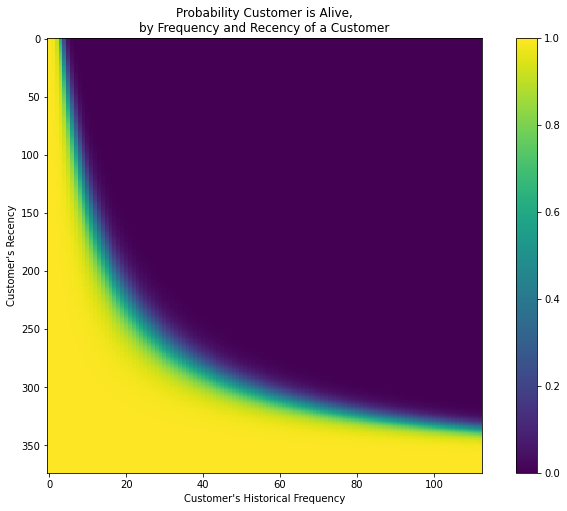

In [ ]:
# Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Calculating CLV also requires defining the appropriate timeframe, here we set the time to half a year.

In [ ]:
# Predict future transaction for the next 30 days based on historical dataa
t = 30 * 6 # determine appropriate timeframe, in this case, 180 days
summary['expected_purchase_6month'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by = 'expected_purchase_6month', ascending = False).head(10).reset_index()

,index,CustomerID,frequency,recency,T,monetary_value,expected_purchase_6month
0,2,12748.0,112.0,373.0,373.0,301.024821,45.84
1,3593,17841.0,111.0,372.0,373.0,364.452162,45.43
2,1771,15311.0,89.0,373.0,373.0,677.729438,36.49
3,1267,14606.0,88.0,372.0,373.0,135.890114,36.09
4,110,12971.0,70.0,369.0,372.0,159.211286,28.84
5,191,13089.0,65.0,367.0,369.0,893.714308,26.99
6,1209,14527.0,53.0,367.0,369.0,155.016415,22.07
7,693,13798.0,52.0,371.0,372.0,706.650962,21.51
8,2580,16422.0,47.0,352.0,369.0,702.472340,19.60
9,902,14096.0,16.0,97.0,101.0,4071.434375,17.72


### Gamma-Gamma Model: Predicting Monetary Value

Here, we adopt the Gamma-Gamma submodel to predict how much average profit t he firm can earn for each customer. After modeling the average profit for the general public, it provides us with the expected average profit per customer.

In [ ]:
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()
return_customers_summary[['frequency', 'monetary_value']].corr()

(2522, 6)


,frequency,monetary_value
frequency,1.00000,0.00954
monetary_value,0.00954,1.00000


In [ ]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 11.13, q: 0.86, v: 11.33>

In [ ]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.133452,0.282670,10.579419,11.687486
q,0.860041,0.021344,0.818207,0.901875
v,11.330566,0.296364,10.749692,11.911440


In [ ]:
# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary.head()

,CustomerID,frequency,recency,T,monetary_value,expected_purchase_6month,exp_avg_sales
1,12747.0,10.0,367.0,369.0,383.745000,4.44,385.362498
2,12748.0,112.0,373.0,373.0,301.024821,45.84,301.159790
3,12749.0,3.0,210.0,213.0,1077.260000,2.44,1085.585845
4,12820.0,3.0,323.0,326.0,257.293333,1.74,262.168769
6,12822.0,1.0,17.0,87.0,257.980000,2.10,272.739188


###Calculating Actual Profit Generated:

It is important to note that the monetary value obtained using the model is the actual sales value, not the profit. Using the above method, we will get the average sales and finally, we can multiply the result by the profit margin to get the actual profit value.

In [ ]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 464.510483302164
Actual Average Sales: 455.5710405734217


###Calculating CLV:

Here we use two separate methods to calculate CLV, one by Lifetime and the other manually.

In [ ]:
summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                summary['frequency'],
                                summary['recency'],
                                summary['T'],
                                summary['monetary_value'],
                                time=1,     # lifetime in months
                                freq='D',   # frequency in which the data is present(T)      
                                discount_rate=0.01) # discount rate
summary.head()

,CustomerID,frequency,recency,T,monetary_value,expected_purchase_6month,exp_avg_sales,predicted_clv
1,12747.0,10.0,367.0,369.0,383.745000,4.44,385.362498,282.571679
2,12748.0,112.0,373.0,373.0,301.024821,45.84,301.159790,2279.769847
3,12749.0,3.0,210.0,213.0,1077.260000,2.44,1085.585845,437.036033
4,12820.0,3.0,323.0,326.0,257.293333,1.74,262.168769,75.402351
6,12822.0,1.0,17.0,87.0,257.980000,2.10,272.739188,94.614601


In [ ]:
summary['manual_predicted_clv'] = summary['expected_purchase_6month'] * summary['exp_avg_sales']
summary.head()

,CustomerID,frequency,recency,T,monetary_value,expected_purchase_6month,exp_avg_sales,predicted_clv,manual_predicted_clv
1,12747.0,10.0,367.0,369.0,383.745000,4.44,385.362498,282.571679,1711.009492
2,12748.0,112.0,373.0,373.0,301.024821,45.84,301.159790,2279.769847,13805.164767
3,12749.0,3.0,210.0,213.0,1077.260000,2.44,1085.585845,437.036033,2648.829461
4,12820.0,3.0,323.0,326.0,257.293333,1.74,262.168769,75.402351,456.173658
6,12822.0,1.0,17.0,87.0,257.980000,2.10,272.739188,94.614601,572.752294


In [ ]:
# CLV in terms of profit (profit margin is 5%)
profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()
summary['CLV'].describe()

count    2522.000000
mean       11.275589
std        45.121311
min         0.136301
25%         2.723332
50%         5.510523
75%        10.571997
max      1690.359722
Name: CLV, dtype: float64

###Quick Customer Segmentation Based on CLV Value:
Finally, we divided the customers into four segmentations by calculating the resulting CLV values.

In [ ]:
clv = summary.copy()
clv["Segment"] =  pd.qcut(clv["predicted_clv"], 4,
                          labels = ['Hibernating','Need Attention',
                                    'Loyal Customers','Champions'])
clv.head()

,CustomerID,frequency,recency,T,monetary_value,expected_purchase_6month,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV,Segment
1,12747.0,10.0,367.0,369.0,383.745000,4.44,385.362498,282.571679,1711.009492,14.128584,Champions
2,12748.0,112.0,373.0,373.0,301.024821,45.84,301.159790,2279.769847,13805.164767,113.988492,Champions
3,12749.0,3.0,210.0,213.0,1077.260000,2.44,1085.585845,437.036033,2648.829461,21.851802,Champions
4,12820.0,3.0,323.0,326.0,257.293333,1.74,262.168769,75.402351,456.173658,3.770118,Need Attention
6,12822.0,1.0,17.0,87.0,257.980000,2.10,272.739188,94.614601,572.752294,4.730730,Need Attention
